In [100]:
#importing libraries and packages
import pandas as pd
import numpy as np
import scipy.stats as ss
import re

import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import os
#pip install linearmodels
from linearmodels import PanelOLS
import math
import statsmodels.formula.api as smf

In [2]:
#set your working directory
#wd="/Users/gargidangwal/Documents/GitHub/Final_Project"
#import zipfile -- for later maybe
#with zipfile.ZipFile("src/original_data/original_data.zip") as zip_ref:
#    zip_ref.extractall("./original_data") 

In [3]:
#Load in dataset
nlsy_data_raw = pd.read_csv("original_data/child_ineq_data.csv")
var_info_raw = pd.read_excel("original_data/var_info.xlsx")

In [4]:
#check for duplicates in nlsy_name
if len(var_info_raw) == len(var_info_raw["nlsy_name"].value_counts()):
    print("nlsy_name is unique")
else:
    print("nlsy_name is not unique")

nlsy_name is unique


In [5]:
# Combine readable_name with survey_year

var_info = var_info_raw
var_info = var_info.astype({'survey_year':'str'})
var_info["readable_name_year"] = var_info["readable_name"] + "_" + var_info["survey_year"]

# Change the time-invariant readable variable names

var_info["readable_name_year"] = var_info["readable_name_year"].str.replace("_invariant","")


In [6]:
def negative_as_missing(value):
    """Returns pandas missing for negative values
    
    Args:
    value (string/float/integer): any value
    
    Returns:
    (string/float): pandas missing if value is negative; else value itself
    
    """
    
    if type(value) != str:
        if value < 0:
            out = np.nan
        else:
            out = value
    else:
        out = value
    return out

In [7]:
nlsy_df = nlsy_data_raw.applymap(negative_as_missing)

In [8]:
### Renaming all variables with readable names
name_dict = dict(zip(var_info["nlsy_name"], var_info["readable_name_year"]))
# name_dict = dict(zip(var_info["nlsy_name"], var_info["readable_name"]))

nlsy_df.rename(columns=(name_dict), inplace=True)

In [9]:
### Keep only those variables that are present in NLSY Variable Information file
droplist = [i for i in nlsy_df.columns if i not in set(var_info["readable_name_year"])]
nlsy_df.drop(droplist,axis=1,inplace=True)

In [10]:
nlsy_df.columns

Index(['individual_id', 'earnings_1978', 'sex', 'participation_1979',
       'weeks_worked_1978', 'hours_worked_1978', 'age_1979', 'earnings_1979',
       'participation_1980', 'age_1980',
       ...
       'hours_worked_2011', 'weeks_worked_2011', 'earnings_2013', 'age_2014',
       'hours_worked_2013', 'weeks_worked_2013', 'earnings_2015', 'age_2016',
       'hours_worked_2015', 'weeks_worked_2015'],
      dtype='object', length=129)

In [11]:
# Change individual_id into integer (is index variable)
print(nlsy_df["individual_id"].dtype)
nlsy_df["individual_id"] = nlsy_df["individual_id"].astype(int)

int64


In [12]:
### Change from wide to long format
varnames_long = set(list(map(lambda x: re.sub("\_[0-9]{4}$","",x), list(nlsy_df.columns)))[3::])
varnames_long

nlsy_df_long = pd.wide_to_long(df=nlsy_df,stubnames = varnames_long,i=["individual_id"],j="year",sep = "_")

In [13]:
#labor market participatiion variable -> 1 if participated 0 if not
nlsy_df_long["participation"] = nlsy_df_long["participation"].replace(list([5,6,7]),0)
nlsy_df_long["participation"] = nlsy_df_long["participation"].replace(list([2,3,4,8]),1)

In [14]:
#load child data
child_data_raw = pd.read_csv("original_data/child_data.csv")
child_var_info = pd.read_excel("original_data/child_var_info.xlsx")

In [15]:
#changing the names of variables
name_dict = dict(zip(child_var_info["nlsy_name"], child_var_info["readable_name"]))
#adapting the names in the data file accordingly
child_data_raw.rename(columns=(name_dict), inplace=True)

In [16]:
# Changing data types
child_data_raw = child_data_raw.astype({'individual_id':'int', 'first_child':'int'})
# Setting individual_id as the index
child_data_raw.set_index(['individual_id'], inplace=True)

In [17]:
child_data = child_data_raw.applymap(negative_as_missing)
child_data = child_data.dropna()

In [18]:
# Merging two dataframe, using individual_id and year as indexes
df = pd.merge(nlsy_df_long, child_data, how="right", on=["individual_id"], right_index = True)

In [19]:
# Creating variables related to the birth of the first child
df = df.reset_index()
df["first_child_birth"] = np.where(df["first_child"] == df["year"], 1, 0)
df["event_time"] = df["year"] - df["first_child"]
df["any_children"] = np.where(df["event_time"] < 0, 0, 1)
df = df.drop(["first_child"], axis=1)

In [20]:
s = df.groupby('individual_id').age.cumcount()
s1 = (df.age - s).groupby(df.individual_id).transform('first')

df['age'] = s1 + s

In [21]:
#setting indices again
df.set_index(['individual_id','year'], inplace=True)

In [22]:
#changing datatypes
df = df.astype({'earnings':'Int64', 'age':'Int64','sex':'Int64',
                'any_children':'Int64','participation':'Int64',
                'weeks_worked':'Int64','hours_worked':'Int64','event_time':'Int64'})
df.dtypes

sex                  Int64
earnings             Int64
weeks_worked         Int64
age                  Int64
participation        Int64
hours_worked         Int64
first_child_birth    int64
event_time           Int64
any_children         Int64
dtype: object

In [23]:
#Summary statistics
df[["earnings", "weeks_worked", "age", "hours_worked","sex"]].describe()

,earnings,weeks_worked,age,hours_worked,sex
count,176614.000000,197601.000000,364455.000000,195136.000000,364455.000000
mean,19865.984814,35.105172,35.803531,1446.200312,1.528732
std,32164.487103,21.201681,11.485393,1048.693265,0.499174
min,0.000000,0.000000,13.000000,0.000000,1.000000
25%,544.250000,14.000000,26.000000,360.000000,1.000000
50%,11000.000000,50.000000,36.000000,1755.000000,2.000000
75%,26000.000000,52.000000,46.000000,2080.000000,2.000000
max,370314.000000,57.000000,59.000000,8736.000000,2.000000


<ipython-input-24-48fc0645c06c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['female'] = np.where(df2["sex"] == 2, 1, 0)


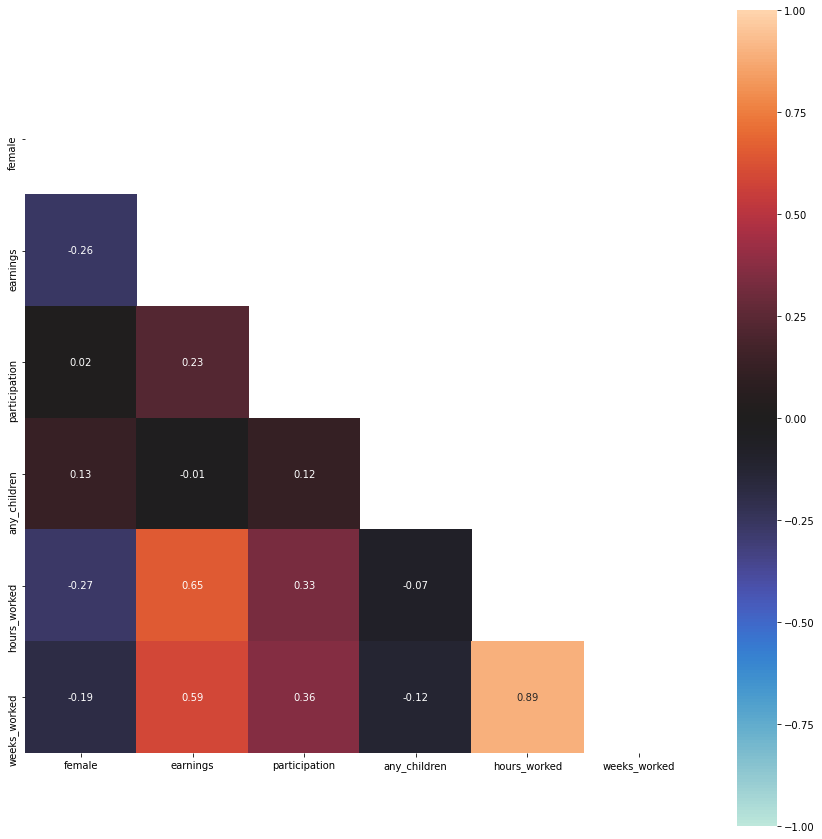

In [24]:
df2 = df.dropna()
df2['female'] = np.where(df2["sex"] == 2, 1, 0)
subscales_selection = ["female","earnings",'participation','any_children','hours_worked','weeks_worked']
subscale_items_columns = []

for subscale in subscales_selection:
    subscale_items = list(filter(lambda x: x.startswith(subscale), df2.columns))
    subscale_items_columns = subscale_items_columns + subscale_items

subscale_items_columns

### Calculate correlation matrix 

corr_matrix = df2[subscale_items_columns].corr()

### Create figure

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
fig_heatmap, axs = plt.subplots(figsize=(15, 15))
axs = sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1, mask=mask, square=True, center=0
)
plt.show()


In [25]:
#restricting the dataset 5 years before and 10 years after the birth of first child
indexNames = df[(df["event_time"] > 10) | (df["event_time"] < -5)].index
indexNames
df.drop(indexNames , inplace=True)

In [26]:
#generating the event_time dummies (where t=-1 is omitted, implying that the event time coefficients measure
#the impact of children relative to the year just before the first child birth)
dummies = pd.get_dummies(df['event_time'])
dummies.columns = [ 'event_time_' + str(dummies) for dummies in range(1,17) ]
dummies = dummies.drop(["event_time_5"], axis=1)
df = pd.concat([df, dummies], axis=1)

In [118]:
#creating a function to create balanced datasets
def gen_balance_df(data, value, sex):
    df_1 = data.groupby(level = 0)[[value]].apply(lambda x: x.isna().sum())
    df_balance = df.loc[df_1.loc[df_1[value]== 0].index]
    df_balance= df_balance.astype(float)
    df_balance = df_balance.drop(df_balance.index[df_balance["sex"]!=sex])
    return df_balance

In [122]:
#creating lists for outcome, gender and result ---- need to check more efficient way for result
outcome = ["hours_worked","participation","earnings"] 
gender = [1, 2]
result = pd.DataFrame(data = {'outcome': ["hours_worked","participation","earnings","hours_worked","participation","earnings"], 'gender': [1, 1, 1, 2, 2, 2]})

In [127]:
def get_reg_result (data, outcome ,gender , result_df ):
    form = outcome + "~  C(age) +event_time_2"
    mod = smf.ols(formula=form, data = data)

  ###  mod = smf.ols(formula='earnings ~  C(age) +event_time_2', data=df)
    res = mod.fit()#add robust SE

    #result_df.loc[ (result_df["outcome"] == outcome  & result_df["gender"] == gender) , "OLS Parameter"] = res.params["event_time_2"].round(3)
    #result_df.loc[ (result_df["outcome"] == outcome  & result_df["gender"] == gender), "OLS SE"] = res.bse["event_time_2"].round(3)
    #result_df.loc[ (result_df["outcome"] == outcome  & result_df["gender"] == gender), "OLS P Value"] = res.pvalues["event_time_2"] 
    result_df.loc[ (result_df["outcome"] == outcome)  , "OLS Parameter"] = res.params["event_time_2"].round(3)
    result_df.loc[ (result_df["outcome"] == outcome) , "OLS SE"] = res.bse["event_time_2"].round(3)
    result_df.loc[ (result_df["outcome"] == outcome), "OLS P Value"] = res.pvalues["event_time_2"] 

In [128]:
for i in outcome:
    for j in gender:
        df_balance = gen_balance_df (df , i, j )
        get_reg_result(df_balance, i, j,  result)

In [129]:
print(result)

         outcome  gender  OLS Parameter    OLS SE   OLS P Value
0   hours_worked       1        336.410    54.588  7.308483e-10
1  participation       1          0.003     0.026  9.004561e-01
2       earnings       1       -148.937  1052.229  8.874684e-01
3   hours_worked       2        336.410    54.588  7.308483e-10
4  participation       2          0.003     0.026  9.004561e-01
5       earnings       2       -148.937  1052.229  8.874684e-01


In [33]:
#balanced datasets
#df_hours_male = gen_balance_df (df , 'hours_worked', 1)
#df_hours_female = gen_balance_df (df , 'hours_worked',2)
#df_participation_male = gen_balance_df (df , 'participation',1)
#df_participation_female = gen_balance_df (df , 'participation',2)
#df_earnings_male = gen_balance_df (df , 'earnings',1)
#df_earnings_female = gen_balance_df (df , 'earnings',2)